In [ ]:
!pip install split-folders

In [ ]:
import feather
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt

import wave, os, glob
%matplotlib inline

import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# sklearn Preprocessing
from sklearn.model_selection import train_test_split
#Keras
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import drive
import splitfolders

In [ ]:
!pwd
!ls

/content
gdrive	sample_data


In [ ]:
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/'CMPT 340 Project'/audio_and_txt_files


Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1e1OTACsf9h9Mi5uoqIsDyb3h904F6VDk/CMPT 340 Project/audio_and_txt_files


In [ ]:
dataset = pd.read_pickle('Final_Data.pkl') 
dataset_sequential = dataset.copy()

In [ ]:
path_to_audio_files = []
for filename in glob.glob(os.path.join('', '*.wav')):
    path_to_audio_files.append(filename)
audio_files_data = pd.DataFrame(path_to_audio_files, columns = ['audio_file'])

In [ ]:
dataset_sequential

,Patient number,Age,Sex,Diagnosis,Binary_diagnosis,Recording index,new BMI,zero_crossing,centroids,energy,rand int i,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,...,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,Chest location_Al,Chest location_Ar,Chest location_Ll,Chest location_Lr,Chest location_Pl,Chest location_Pr,Chest location_Tc,Acquisition mode_mc,Acquisition mode_sc,Recording equipment_AKGC417L,Recording equipment_Litt3200,Recording equipment_LittC2SE,Recording equipment_Meditron
0,101,3.00,0,URTI,Unhealthy,1b1,19.385777,834,862,24.354544,-1,-583.074829,95.407684,57.615402,31.388035,28.196554,33.571594,31.646765,22.791107,16.666695,15.631426,14.037862,9.235232,5.834866,7.332277,10.597386,10.617828,7.180680,3.737869,2.680353,3.642111,5.495842,7.373888,8.116691,6.516584,3.175952,0.672749,0.915031,3.079237,4.896942,...,1.728973e-07,1.738731e-07,1.769270e-07,1.728405e-07,1.709613e-07,1.697057e-07,1.698561e-07,1.716227e-07,1.743128e-07,1.806536e-07,1.831783e-07,1.743893e-07,1.328132e-07,1.112076e-07,24.108521,12.576147,13.513313,14.723985,16.083529,13.537544,28.755852,-0.015893,0.028519,-0.082620,0.048922,0.035543,0.010514,0,0,0,0,0,1,0,0,1,0,0,0,1
1,101,3.00,0,URTI,Unhealthy,1b1,19.385777,938,862,40.098251,-1,-529.150757,104.431587,70.155006,42.595573,31.283190,27.506977,22.269215,16.563374,15.326893,16.716825,14.707142,8.446252,3.871402,4.893015,8.417205,9.325685,6.879937,3.962098,2.855496,3.370863,4.458168,5.342813,5.608436,4.753032,2.933595,1.404434,1.264880,2.176501,3.008374,...,2.542159e-07,2.599661e-07,2.753871e-07,2.632678e-07,2.556239e-07,2.714140e-07,2.835432e-07,3.009890e-07,3.235409e-07,3.527952e-07,4.131382e-07,5.203320e-07,6.602992e-07,7.155102e-07,21.529142,11.710819,13.348330,14.907793,16.954568,13.540970,28.758001,0.024129,0.015229,-0.107902,0.014130,0.014674,-0.004861,1,0,0,0,0,0,0,0,1,0,0,0,1
2,102,0.75,0,Healthy,Healthy,1b1,18.389942,1009,862,15.837536,-1,-596.955933,116.085419,60.695057,25.555992,26.209230,38.512352,36.051533,18.640724,3.533884,0.808337,5.736544,9.657865,9.137486,5.530644,2.170750,2.102858,5.248150,7.930713,7.101245,4.055319,2.352255,3.208253,4.845040,5.344265,4.519351,3.379910,2.771019,2.687288,2.583400,...,1.025937e-07,1.011247e-07,1.017891e-07,1.008913e-07,9.857648e-08,9.736862e-08,9.689317e-08,9.504856e-08,9.403183e-08,9.480667e-08,9.228317e-08,7.141852e-08,2.596839e-08,3.352563e-09,22.001710,11.461202,14.800548,15.227452,15.865647,13.587686,28.836766,0.059854,0.050555,-0.053679,0.046902,0.007503,0.004685,0,1,0,0,0,0,0,0,1,0,0,0,1
3,103,70.00,0,Asthma,Unhealthy,2b2,33.000000,488,862,186.288315,-1,-418.969116,68.048729,48.216747,33.118893,28.064762,26.474794,22.738909,18.174431,15.947225,15.115901,13.330146,10.850938,9.652020,9.752692,9.589607,8.603680,7.715221,7.177804,6.387998,5.581184,6.114264,8.006547,9.114248,7.700382,4.964710,3.453428,3.851614,4.572692,4.400282,...,5.289392e-06,5.336612e-06,5.191538e-06,5.276675e-06,5.260073e-06,5.255692e-06,5.190956e-06,5.252671e-06,5.408156e-06,5.760773e-06,6.362526e-06,7.415628e-06,8.920741e-06,9.502831e-06,30.061463,11.485268,12.791700,12.860103,15.066477,13.813717,29.405788,-0.011169,0.028254,-0.085533,0.052930,0.023058,0.015778,0,1,0,0,0,0,0,1,0,0,0,1,0
4,104,70.00,0,COPD,Unhealthy,1b1,28.470000,831,648,56.509598,-1,-424.268616,59.955784,50.275135,38.291904,27.447374,19.641413,15.319858,14.077450,14.971409,16.690376,17.948116,17.959871,16.606979,14.217122,11.247156,8.132569,5.296245,3.138010,1.914241,1.616304,2.000694,2.753793,3.620424,4.395525,4.869637,4.867006,4.361364,3.522510,2.622871,...,4.886360e-09,4.704167e-09,4.539293e-09,4.387901e-09,4.252693e-09,4.133347e-09,4.022551e-09,3.930130e-09,3.847529e-09,3.776099e-09,3.719050e-09,3.672473e-09,3.640387e-09,3.618832e-09,24.231688,14.313585,17.410904,19.179523,40.675148,19.165556,19.578840,-0.020600,0.016854,-0.102233,0.004000,0.017646,0.002610,0,0,0,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,.

In [ ]:
dataset_sequential.columns = dataset_sequential.columns.map(str)

start = dataset_sequential.columns.get_loc("0") 
end = dataset_sequential.columns.get_loc("192")

data = dataset_sequential.iloc[:, start: end]

patient_diagnosis = dataset_sequential[["Patient number", "Diagnosis"]]

In [ ]:
patient_number = np.array(dataset_sequential["Patient number"])
diagnosis = np.array(dataset_sequential["Diagnosis"])
dic={}
for i in range(patient_number.size):
  temp = {'{}'.format(patient_number[i]) : '{}'.format(diagnosis[i])}
  # temp[patient_number[i]] = diagnosis[i]
  dic.update(temp)

In [ ]:
for d in diagnosis:# make folders acc to diagnosis number
    pathlib.Path(f'/content/gdrive/MyDrive/CMPT 340 Project/image_data/{d}').mkdir(parents=True, exist_ok=True) 

In [ ]:
for filename in audio_files_data.audio_file:
    if (filename[:3]) in patient_number:
      # print(dic[(filename[:3])])
      y, sr = librosa.load(filename, mono=True, duration=5)
      plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, sides='default', mode='default', scale='dB');
      plt.axis('off');
      plt.savefig(f'/content/gdrive/MyDrive/CMPT 340 Project/image_data/{dic[(filename[:3])]}/{filename[:-4]}.png')
      plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
splitfolders.ratio('/content/gdrive/MyDrive/CMPT 340 Project/image_data', output="/content/gdrive/MyDrive/CMPT 340 Project/data", seed=1337, ratio=(.8, .2))

Copying files: 877 files [00:18, 47.23 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        rescale=1./255, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True)

In [ ]:
training_set = train_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/CMPT 340 Project/Data/train',
        target_size=(64, 64),
        batch_size=1,
        class_mode='categorical',
        shuffle = False)

test_set = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/CMPT 340 Project/Data/val',
        target_size=(64, 64),
        batch_size=1,
        class_mode='categorical',
        shuffle = False )

Found 697 images belonging to 6 classes.
Found 178 images belonging to 6 classes.


In [ ]:
model = Sequential()
input_shape=(64, 64, 3)#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))#Output layer
model.add(Dense(6))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
average_pooling2d_4 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
activation_6 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)         

In [ ]:
epochs = 255
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

In [13]:
history = model.fit(
        training_set,
        steps_per_epoch=50,
        epochs=50,
        validation_data=test_set,
        validation_steps=165)

Epoch 1/50
50/50 [==============================] - 44s 893ms/step - loss: 0.5182 - accuracy: 0.9200 - val_loss: 0.3690 - val_accuracy: 0.9455
Epoch 2/50
50/50 [==============================] - 12s 236ms/step - loss: 0.9194 - accuracy: 0.8400 - val_loss: 0.4375 - val_accuracy: 0.9455
Epoch 3/50
50/50 [==============================] - 11s 224ms/step - loss: 0.6048 - accuracy: 0.9200 - val_loss: 0.3027 - val_accuracy: 0.9455
Epoch 4/50
50/50 [==============================] - 10s 191ms/step - loss: 0.4176 - accuracy: 0.9400 - val_loss: 0.2802 - val_accuracy: 0.9455
Epoch 5/50
50/50 [==============================] - 10s 201ms/step - loss: 0.6976 - accuracy: 0.8600 - val_loss: 0.3712 - val_accuracy: 0.9455
Epoch 6/50
50/50 [==============================] - 9s 174ms/step - loss: 0.9069 - accuracy: 0.8600 - val_loss: 0.2854 - val_accuracy: 0.9455
Epoch 7/50
50/50 [==============================] - 9s 172ms/step - loss: 0.8433 - accuracy: 0.8600 - val_loss: 0.3852 - val_accuracy: 0.9455
E

In [ ]:
model.evaluate_generator(generator=test_set, steps=50)

[0.6827704906463623, 0.8399999737739563]

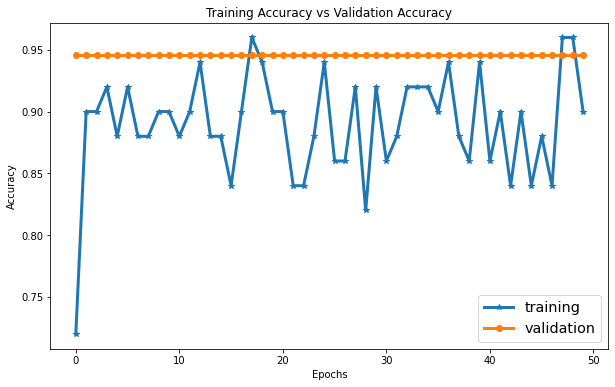

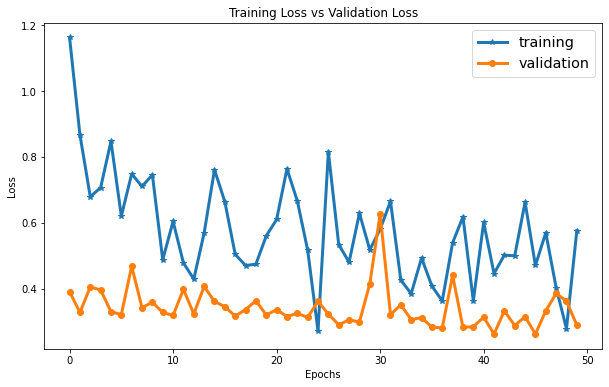

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()
visualize_training(history)